# Task 1 : Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 97 kB 5.2 MB/s 
     |████████████████████████████████| 58 kB 8.5 MB/s 
     |████████████████████████████████| 376 kB 56.4 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=df8954001db0db70b9c80cd37bc9ca4752749f89f6e1a19dcb7f75eb43195bbd
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=939c20e941a9b91c11ee8e9ebd12cf3a808f34570e70adf7d0009e8c6bf35acb
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning htt

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [2]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 587 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 26.53 MiB/s, done.
Resolving deltas: 100% (3/3), done.


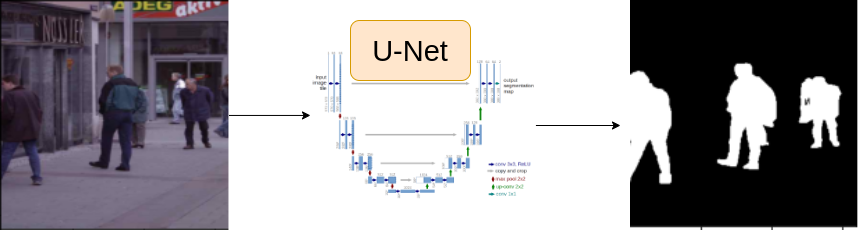

# Some Common Imports

In [3]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [4]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [65]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content/'

DEVICE = 'cuda'

EPOCHS=25
LR=0.003
IMAGE_SIZE= 320
BATCH_SIZE=16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [6]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [9]:
row = df.iloc[14]
image_path= row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
mask = cv2.imread(mask_path , cv2.IMREAD_GRAYSCALE)/255

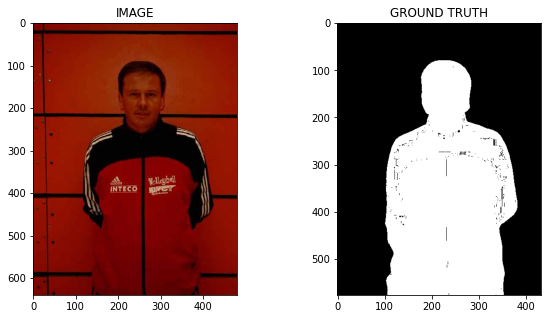

In [10]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [11]:
train_df, valid_df= train_test_split(df, test_size=0.2, random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [16]:
import albumentations as A

In [27]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE,IMAGE_SIZE),
      A.HorizontalFlip(p=.5),
      A.VerticalFlip(p=.5)
  ])
def get_valid_augs():
    return A.Compose([
      A.Resize(IMAGE_SIZE,IMAGE_SIZE)
  ])

# Task 4 : Create Custom Dataset 

In [34]:
from torch.utils.data import Dataset

In [50]:
class SegmentationDataset(Dataset):
  def __init__(self, df, augmentations):
    self.df =df
    self.augmentations = augmentations
  
  def __len__(self):
    return len(self.df)
  
  def __getitem__(self, idx):
    row = self.df.iloc[idx]
    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path , cv2.IMREAD_GRAYSCALE)
    mask = np.expand_dims(mask, axis=-1)

    if self.augmentations:
      data = self.augmentations(image=image, mask= mask)
      image = data['image']
      mask = data['mask']

      image = np.transpose(image, (2,0,1)).astype(np.float32)
      mask = np.transpose(mask, (2,0,1)).astype(np.float32)

      image = torch.Tensor(image)/255.0
      mask = torch.round(torch.Tensor(mask)/255.0)

      return image,mask
      

In [51]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [52]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


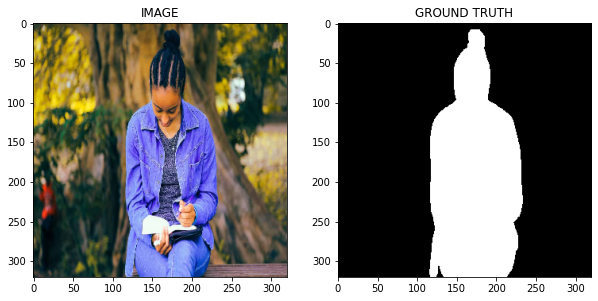

In [56]:
idx = 30

image, mask = trainset[idx]
helper.show_image(image,mask)

# Task 5 : Load dataset into batches

In [57]:
from torch.utils.data import DataLoader

In [58]:
trainloader = DataLoader(trainset,batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [59]:
print(f"Total number of batches in train loader:  {len(trainloader)}")
print(f"Total number of batches in valid loader:  {len(validloader)}")

Total number of batches in train loader:  15
Total number of batches in valid loader:  4


In [61]:
for image,mask in trainloader:
  break

print(f"One Batch Image Shape: {image.shape}")
print(f"One Batch Mask Shape: {mask.shape}")

One Batch Image Shape: torch.Size([16, 3, 320, 320])
One Batch Mask Shape: torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [62]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss


In [82]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights= WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None
    )

  def forward(self,images,masks=None):
    logits = self.arc(images)

    if masks != None:
      loss1 = DiceLoss(mode='binary')(logits,masks)
      loss2 = nn.BCEWithLogitsLoss()(logits,masks)
      return logits,loss1+loss2
    return logits

In [83]:
model = SegmentationModel()
model.to(DEVICE)


SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): Swish()
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act1): Swish()
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
            (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn2): BatchNorm2d(16, eps

# Task 7 : Create Train and Validation Function 

In [84]:
def train_fn(data_loader, model, optimizer):
  model.train()
  total_loss = 0

  for images,masks in tqdm(data_loader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images,masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss/len(data_loader) 

In [88]:
def eval_fn(data_loader, model):
  model.eval()
  total_loss = 0
  with torch.no_grad():
    for images,masks in tqdm(data_loader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      
      logits, loss = model(images,masks)
      
      

      total_loss += loss.item()

  return total_loss/len(data_loader) 

# Task 8 : Train Model

In [89]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)


In [90]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader,model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(),'best_model.pt')
    print("Saved Model")
    best_valid_loss = valid_loss
  
  print(f"Eposch = {i+1} Train loss : {train_loss} Valid loss {valid_loss}")

100%|██████████| 4/4 [00:00<00:00,  4.86it/s]


Saved Model
Eposch = 1 Train loss : 0.4311606248219808 Valid loss 0.6088281944394112


100%|██████████| 4/4 [00:00<00:00,  4.78it/s]


Saved Model
Eposch = 2 Train loss : 0.37019399404525755 Valid loss 0.3062575161457062


100%|██████████| 4/4 [00:00<00:00,  4.89it/s]


Eposch = 3 Train loss : 0.2780136873324712 Valid loss 0.3376280143857002


100%|██████████| 4/4 [00:00<00:00,  4.86it/s]


Saved Model
Eposch = 4 Train loss : 0.2634096304575602 Valid loss 0.27260131388902664


100%|██████████| 4/4 [00:00<00:00,  4.74it/s]


Saved Model
Eposch = 5 Train loss : 0.25500727792580924 Valid loss 0.2717323489487171


100%|██████████| 4/4 [00:00<00:00,  4.81it/s]


Saved Model
Eposch = 6 Train loss : 0.21893770297368367 Valid loss 0.26206405088305473


100%|██████████| 4/4 [00:00<00:00,  4.84it/s]


Saved Model
Eposch = 7 Train loss : 0.18327551583449045 Valid loss 0.24836165457963943


100%|██████████| 4/4 [00:00<00:00,  4.80it/s]


Saved Model
Eposch = 8 Train loss : 0.17504997154076893 Valid loss 0.22184186056256294


100%|██████████| 4/4 [00:00<00:00,  4.81it/s]


Saved Model
Eposch = 9 Train loss : 0.22515826374292375 Valid loss 0.1835353821516037


100%|██████████| 4/4 [00:00<00:00,  4.83it/s]


Eposch = 10 Train loss : 0.1810152754187584 Valid loss 0.23146488517522812


100%|██████████| 4/4 [00:00<00:00,  4.81it/s]


Eposch = 11 Train loss : 0.17670903901259105 Valid loss 0.21653402224183083


100%|██████████| 4/4 [00:00<00:00,  4.82it/s]


Eposch = 12 Train loss : 0.17774814367294312 Valid loss 0.19135653972625732


100%|██████████| 4/4 [00:00<00:00,  4.84it/s]


Eposch = 13 Train loss : 0.15016230245431264 Valid loss 0.25529446452856064


100%|██████████| 4/4 [00:00<00:00,  4.78it/s]


Eposch = 14 Train loss : 0.1256591225663821 Valid loss 0.18623825535178185


100%|██████████| 4/4 [00:00<00:00,  4.85it/s]


Eposch = 15 Train loss : 0.12041795104742051 Valid loss 0.2564290538430214


100%|██████████| 4/4 [00:00<00:00,  4.55it/s]


Eposch = 16 Train loss : 0.12980810900529224 Valid loss 0.2141960896551609


100%|██████████| 4/4 [00:00<00:00,  4.88it/s]


Eposch = 17 Train loss : 0.17518460303544997 Valid loss 0.230849988758564


100%|██████████| 4/4 [00:00<00:00,  4.84it/s]


Eposch = 18 Train loss : 0.19485211024681728 Valid loss 0.23000694438815117


100%|██████████| 4/4 [00:00<00:00,  4.87it/s]


Eposch = 19 Train loss : 0.17722143630186718 Valid loss 0.22206984087824821


100%|██████████| 4/4 [00:00<00:00,  4.80it/s]


Eposch = 20 Train loss : 0.1472159261504809 Valid loss 0.19772524014115334


100%|██████████| 4/4 [00:00<00:00,  4.82it/s]


Eposch = 21 Train loss : 0.11100210497776668 Valid loss 0.1855324599891901


100%|██████████| 4/4 [00:00<00:00,  4.83it/s]


Eposch = 22 Train loss : 0.10808371603488923 Valid loss 0.18377255648374557


100%|██████████| 4/4 [00:00<00:00,  4.81it/s]


Eposch = 23 Train loss : 0.09994706312815348 Valid loss 0.18776149302721024


100%|██████████| 4/4 [00:00<00:00,  4.84it/s]


Saved Model
Eposch = 24 Train loss : 0.10001063048839569 Valid loss 0.15955978073179722


100%|██████████| 4/4 [00:00<00:00,  4.82it/s]

Eposch = 25 Train loss : 0.11517446090777715 Valid loss 0.2937986869364977


# Task 9 : Inference

In [94]:
idx = 8 

model.load_state_dict(torch.load('/content/best_model.pt'))
image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0))
pred_mask = torch.sigmoid(logits_mask)

pred_mask = (pred_mask>0.5)*1.0

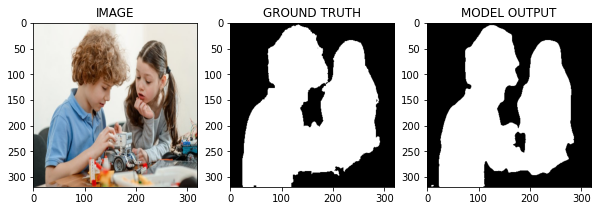

In [95]:
helper.show_image(image,mask,pred_mask.detach().cpu().squeeze(0))